In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

Epoch 0, Loss: 1.22671437
Epoch 100, Loss: 0.02627449
Epoch 200, Loss: 0.02569433
Epoch 300, Loss: 0.02483070
Epoch 400, Loss: 0.02316277
Epoch 500, Loss: 0.01937562
Epoch 600, Loss: 0.01103471
Epoch 700, Loss: 0.00282387
Epoch 800, Loss: 0.00075356
Epoch 900, Loss: 0.00053696
Epoch 1000, Loss: 0.00045714
Epoch 1100, Loss: 0.00039627
Epoch 1200, Loss: 0.00034617
Epoch 1300, Loss: 0.00030415
Epoch 1400, Loss: 0.00026824
Epoch 1500, Loss: 0.00023685
Epoch 1600, Loss: 0.00020876
Epoch 1700, Loss: 0.00018315
Epoch 1800, Loss: 0.00015961
Epoch 1900, Loss: 0.00013798


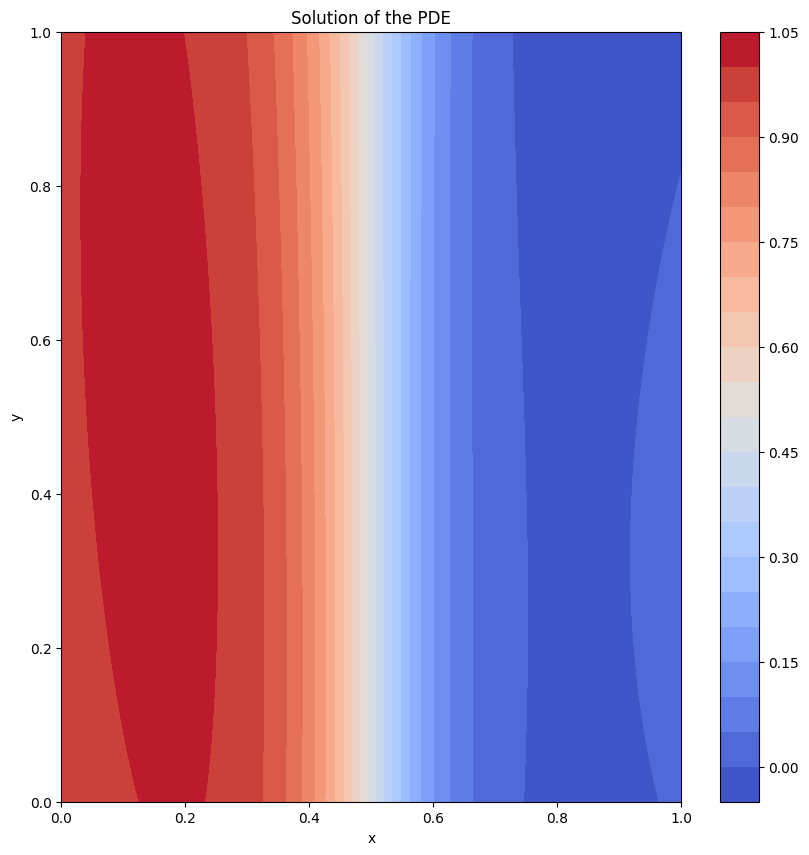

In [5]:
class PINN(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(PINN, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


def dirichlet_loss(model, boundary_points, boundary_targets):
    u_pred = model(boundary_points)
    return torch.mean((u_pred - boundary_targets) ** 2)


def gradient_loss(model, flat_points):
    u_pred = model(flat_points)
    grads = torch.autograd.grad(u_pred, flat_points, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    du_dy = grads[:, 1]  # Gradient with respect to y
    return torch.mean(du_dy ** 2)


# Boundary points for Dirichlet conditions
boundary_points_1 = torch.cat([torch.linspace(0, 0.3, 100).unsqueeze(1), 0.2 * torch.ones(100, 1)], dim=1).requires_grad_(True)
boundary_targets_1 = torch.ones(100, 1)  # u = 1

boundary_points_0 = torch.cat([torch.linspace(0.7, 1, 100).unsqueeze(1), 0.2 * torch.ones(100, 1)], dim=1).requires_grad_(True)
boundary_targets_0 = torch.zeros(100, 1)  # u = 0

# Points for the flat region gradient condition
flat_points = torch.cat([torch.linspace(0.3, 0.7, 100).unsqueeze(1), 0.2 * torch.ones(100, 1)], dim=1).requires_grad_(True)

def total_loss(model, boundary_points_1, boundary_targets_1, boundary_points_0, boundary_targets_0, flat_points):
    loss_d1 = dirichlet_loss(model, boundary_points_1, boundary_targets_1)
    loss_d0 = dirichlet_loss(model, boundary_points_0, boundary_targets_0)
    loss_g = gradient_loss(model, flat_points)
    return loss_d1 + loss_d0 + loss_g



# Initialize the model and optimizer
model = PINN(hidden_size=40, hidden_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = total_loss(model, boundary_points_1, boundary_targets_1, boundary_points_0, boundary_targets_0, flat_points)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.8f}")

# Plot the solution
x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
points = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)
solution = model(points).detach().numpy().reshape(1000, 1000)

plt.figure(figsize=(10, 10))
plt.contourf(X, Y, solution, levels=20, cmap="coolwarm")
plt.colorbar()
plt.title("Solution of the PDE")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


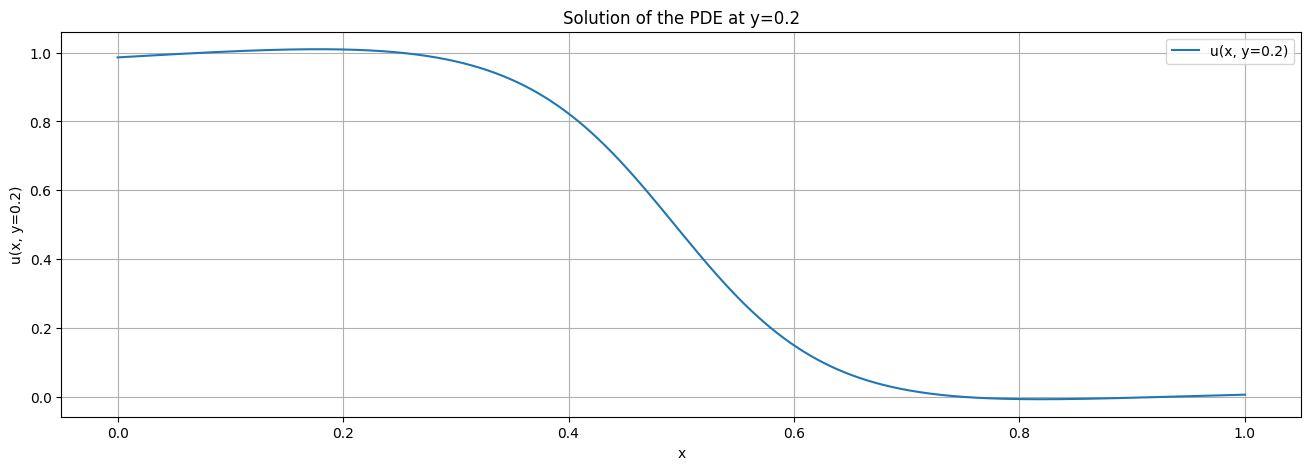

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x values (0 to 1) and keep y fixed at 0.2
x = np.linspace(0, 1, 1000)  # 1000 points along x
y = np.full_like(x, 0.2)     # Keep y constant at 0.2

# Combine x and y into points for evaluation
points = torch.tensor(np.c_[x, y], dtype=torch.float32)

# Evaluate the model
solution = model(points).detach().numpy()

# Plot the solution
plt.figure(figsize=(16, 5))
plt.plot(x, solution, label="u(x, y=0.2)")
plt.title("Solution of the PDE at y=0.2")
plt.xlabel("x")
plt.ylabel("u(x, y=0.2)")
plt.grid()
plt.legend()
plt.show()

